### Feature Analysis: Interpretability of ML models
March 2022

**Import Libraries**

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import sys
import os

from utils import *
#from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)

%matplotlib inline
scoring_metric = "accuracy"

**Import and inspect Data**

In [21]:
path = os.getcwd()
data = pd.read_excel(os.path.join(path, "data/pumpkin.xlsx"), sheet_name = "Pumpkin_Seeds_Dataset")

In [22]:
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [37]:
data = data.rename(columns=str.lower)

In [38]:
data.area.value_counts()

75637    3
97268    3
68063    3
96928    2
76461    2
        ..
76581    1
70110    1
66208    1
80529    1
80011    1
Name: area, Length: 2424, dtype: int64

**Define column types for column transformation**

In [42]:
numeric_columns = data.columns[1:-1]
target_column = "class"
drop_column = ["area"]

In [43]:
numeric_transformer = make_pipeline(StandardScaler())

preprocessor = make_column_transformer(
    ("drop", drop_column),
    (numeric_transformer, numeric_columns)
)

**Split Data**

In [46]:
train, test = train_test_split(data, test_size=0.2, random_state=2022)

X_train = train.drop(columns=[target_column])
y_train = train[target_column]

X_test = test.drop(columns=[target_column])
y_test = test[target_column]

**Check for class Balance**

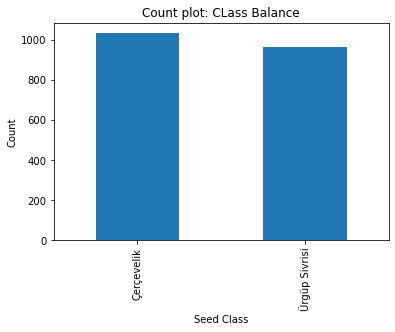

In [59]:
train["class"].value_counts().plot(kind = "bar",
                                   title = "Count plot: CLass Balance",
                                   xlabel = "Seed Class",
                                   ylabel = "Count"
                                  );

In [50]:
# not a perfect balance, but we can work with this

In [ ]:
df.plot(